# Spinup of PST mode

The some initial condition of urban surface and land porperty will affect the output of CLMU.

In [1]:
from pyclmuapp import pts_clmu
from pyclmuapp import usp_clmu
from pyclmuapp.getcity import *
import matplotlib.pyplot as plt
import pandas as pd
import os

## 1 PTS mode: using the CESM provide global data

workflow
1. get the urban location
2. revise the case configuration
3. run the case

PTS mode need to define the resolution of the grid. Here, the default resolution is ~1 degree, the CESM nominal resolution. 

The resolution can be changed by `pts.caseconfig['resolution']`. 

Why choose the CESM nominal resolution?

1. Most ESMs are simulated at such a coarse resolution, and using this resolution will be helpful to apply our case to other ESMs and to form a stable decision based on multiple ESMs in the future. 
   
2. Coarse-resolution data is easy to obtain due to its generalizability and data volume. 
   
3. Simulation based on coarse resolution can know the urban climate from a macroscopic view, which in turn can form a macroscopic goal to guide the refinement of future urban climate adaptation planning. 
   
4. This resolution of CLMU output has been validated.

### 1.1 Get the urban grid location

In [8]:
# the mask if from UrbanClimateExplorer/docs/notebooks/CESM1_get_urban_areas_mask.ipynb
# https://github.com/zhonghua-zheng/UrbanClimateExplorer/blob/main/docs/notebooks/CESM1_get_urban_areas_mask.ipynb
mask = pd.read_csv("src/CESM1_urban_mask.csv", index_col=0)
citylist = get_mask_cities(mask)


# set the location of London
London = {'lat': 51.5, 'lon': -0.1}

# find the closest city grid point to London (resolution is 1 degree, CESM nominal resolution)
closecity = closest(citylist,London)

closecity

{'lat': 51.361255645752, 'lon': 0.0}

### 1.2 revise the caseconfig and run case

note: the docker container (named **myclmu**) should be running and bind the input_path, output_path, log_path and scripts_path

if not use the `pts.docker(cmd='run')` to start the container, this will help to bind above paths automatically.

In [ ]:
# initialize the pts_clmu object

pts = pts_clmu(
    pwd=None,
    input_path="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata",
    output_path="/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist",
    log_path="/home/zhonghua/p/scratch/CESMDATAROOT/CaseOutputs",
    scripts_path = "/home/zhonghua/p/scripts",
    container_type='docker')

pts.caseconfig['case_name'] = 'pst_no_spinup'
pts.caseconfig['case_length'] = "2"
pts.caseconfig['hist_nhtfrq'] = '1'
pts.caseconfig['STOP_OPTION'] = "nyears"
pts.caseconfig['hist_mfilt']='240000'
pts.caseconfig['output_murban'] = 'False' # output the whole urban area weather (if True, the output the TBD, HD and MD urban)
pts.caseconfig['mu_urban'] = "'TSA_U'" # output the TBD urban area weather
pts.caseconfig['RUN_STARTDATE'] = '2012-01-01'
pts.caseconfig['case_lat'] = str(closecity['lat'])
pts.caseconfig['case_lon'] = str(closecity['lon'])
nospinup_pts = pts.run(iflog=True, cmdlogfile='pts_London.log')

In [ ]:
pts = pts_clmu(
    pwd=None,
    input_path="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata",
    output_path="/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist",
    log_path="/home/zhonghua/p/scratch/CESMDATAROOT/CaseOutputs",
    scripts_path = "/home/zhonghua/p/scripts",
    container_type='docker')

pts.caseconfig['case_name'] = 'pst_spinup'
pts.caseconfig['case_length'] = "12"
pts.caseconfig['hist_nhtfrq'] = '1'
pts.caseconfig['STOP_OPTION'] = "nyears"
pts.caseconfig['hist_mfilt']='240000'
pts.caseconfig['output_murban'] = 'False' # output the whole urban area weather (if True, the output the TBD, HD and MD urban)
pts.caseconfig['mu_urban'] = "'TSA_U'" # output the TBD urban area weather
pts.caseconfig['RUN_STARTDATE'] = '2002-01-01'
pts.caseconfig['case_lat'] = str(closecity['lat'])
pts.caseconfig['case_lon'] = str(closecity['lon'])

spinup_pts = pts.run(iflog=True, cmdlogfile='pts_London_spinup.log',spinup=True)

In [ ]:
ds_nospinup = pts.nc_view(nospinup_pts[0])
ds_spinup = pts.nc_view(spinup_pts[0])

**compare the two simulation results**

-0.002765288


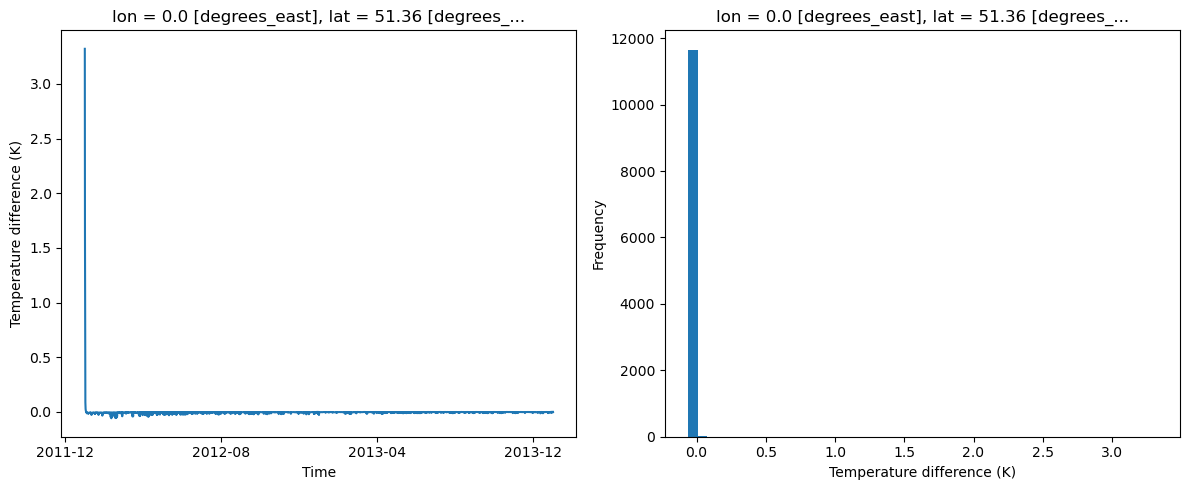

In [3]:
fig = plt.figure(figsize=(12, 5))
ds_spinup = ds_spinup.sel(time=slice('2012','2014'))
#
diff = ds_nospinup['TSA_U'] - ds_spinup['TSA_U']

print(diff.mean().values)

ax = fig.add_subplot(121)
diff.plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature difference (K)')

ax = fig.add_subplot(122)
diff.plot.hist(ax=ax, bins=50)

ax.set_xlabel('Temperature difference (K)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.3 clean up the case if needed 
this will need the permission to delete the case folder, if not, please do it manually.
    
the case folder is in the **log_path** and **scripts_path** with a name of the **case_name**

In [ ]:
pts.case_clean()

## 2 usp mode

workflow
1. initialize
   
    note: the docker container (named **myclmu**) should be running and bind the input_path, output_path, log_path and scripts_path
    if not use the `usp.docker(cmd='run')` to start the container, this will help to bind above paths automatically.
2. check domian
3. check forcing
   
   must define the forcing file
4. run case

In [2]:
# initialize
usp = usp_clmu(
    pwd=None,
    input_path="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata",
    output_path="/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist",
    log_path="/home/zhonghua/p/scratch/CESMDATAROOT/CaseOutputs",
    scripts_path = "/home/zhonghua/p/scripts",
    container_type='docker')

# check surface
usp.check_surf(usr_surfdata="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/Urban-PLUMBER/input_files/UK-Kin/surfdata_1x1_UK-Kin_detailed_simyr2000_c230710.nc")
# check the domain
# the domain file will be revised according to the surface data if usr_domain is not provided
usp.check_domain()
# check the forcing
usp.check_forcing(
    usr_forcing="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/Urban-PLUMBER/datm_files/UK-Kin/CLM1PT_data/CTSM_DATM_UK-Kin_2002-2014.nc")

nospinup = usp.run(
            output_prefix= "_clm.nc",
            case_name = "no_spinup", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            iflog = True,
            logfile = "log.log",
            #var_add= "'Qle','Qh','Qtau','Qstor','Rnet','SWup','LWup'",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
nospinup

Folder '/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/usp' created successfully!
Copying the file CTSM_DATM_UK-Kin_2002-2014.nc to the /home/zhonghua/p/scratch/CESMDATAROOT/inputdata/usp


['/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist/no_spinup_clm0_2024-05-14_17-10-49_clm.nc']

In [5]:
# initialize
usp = usp_clmu(
    pwd=None,
    input_path="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata",
    output_path="/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist",
    log_path="/home/zhonghua/p/scratch/CESMDATAROOT/CaseOutputs",
    scripts_path = "/home/zhonghua/p/scripts",
    container_type='docker')

# check surface
usp.check_surf(usr_surfdata="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/Urban-PLUMBER/input_files/UK-Kin/surfdata_1x1_UK-Kin_detailed_simyr2000_c230710.nc")
# check the domain
# the domain file will be revised according to the surface data if usr_domain is not provided
usp.check_domain()
# check the forcing
usp.check_forcing(
    usr_forcing="/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/Urban-PLUMBER/datm_files/UK-Kin/CLM1PT_data/CTSM_DATM_UK-Kin_2002-2014.nc")

spinup_usp = usp.run(
            output_prefix= "_clm.nc",
            case_name = "spinup", 
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "12",
            iflog = True,
            logfile = "log.log",
            #var_add= "'Qle','Qh','Qtau','Qstor','Rnet','SWup','LWup'",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
spinup_usp

Folder '/home/zhonghua/p/scratch/CESMDATAROOT/inputdata/usp' already exists.
The file CTSM_DATM_UK-Kin_2002-2014.nc already exists.
The /home/zhonghua/p/scratch/CESMDATAROOT/inputdata/usp/usp.sh already exists.
The /home/zhonghua/p/scratch/CESMDATAROOT/inputdata/usp/SourceMods already exists.


['/home/zhonghua/p/scratch/CESMDATAROOT/Archive/lnd/hist/spinup_clm0_2024-05-14_17-22-26_clm.nc']

In [6]:
ds_usp_nospinup = usp.nc_view(nospinup[0])
ds_usp_spinup = usp.nc_view(spinup_usp[0])

In [14]:
ds_usp_spinup = ds_usp_spinup.sel(time=slice('2012','2014'))
ds_usp_nospinup['TSA_U'].values.shape, ds_usp_spinup['TSA_U'].values.shape

((35089, 1), (35089, 1))

0.09029324
0.07257847


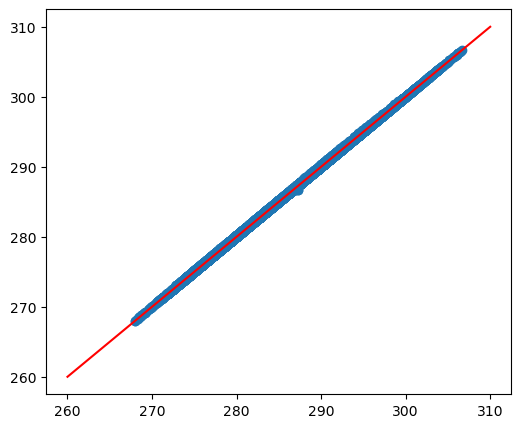

In [21]:
import numpy as np
fig = plt.figure(figsize=(6, 5))
ds_usp_spinup = ds_usp_spinup.sel(time=slice('2012','2014'))
plt.scatter(ds_usp_nospinup['TSA_U'].values, ds_usp_spinup['TSA_U'].values)
plt.plot([260, 310], [260, 310], color='red')
square_error = np.square(ds_usp_nospinup['TSA_U'].values - ds_usp_spinup['TSA_U'].values)
rmse = np.sqrt(square_error.mean())
print(rmse)
error = np.abs(ds_usp_nospinup['TSA_U'].values - ds_usp_spinup['TSA_U'].values)
print(error.mean())

In [22]:
JJA_no = ds_usp_nospinup.sel(time=ds_usp_nospinup['time.season']=='JJA')
JJA = ds_usp_spinup.sel(time=ds_usp_spinup['time.season']=='JJA')

square_error = np.square(JJA_no['TSA_U'].values - JJA['TSA_U'].values)
rmse = np.sqrt(square_error.mean())
print(rmse)
error = np.abs(JJA_no['TSA_U'].values - JJA['TSA_U'].values)
print(error.mean())

0.08860679
0.06793207


-0.07235429


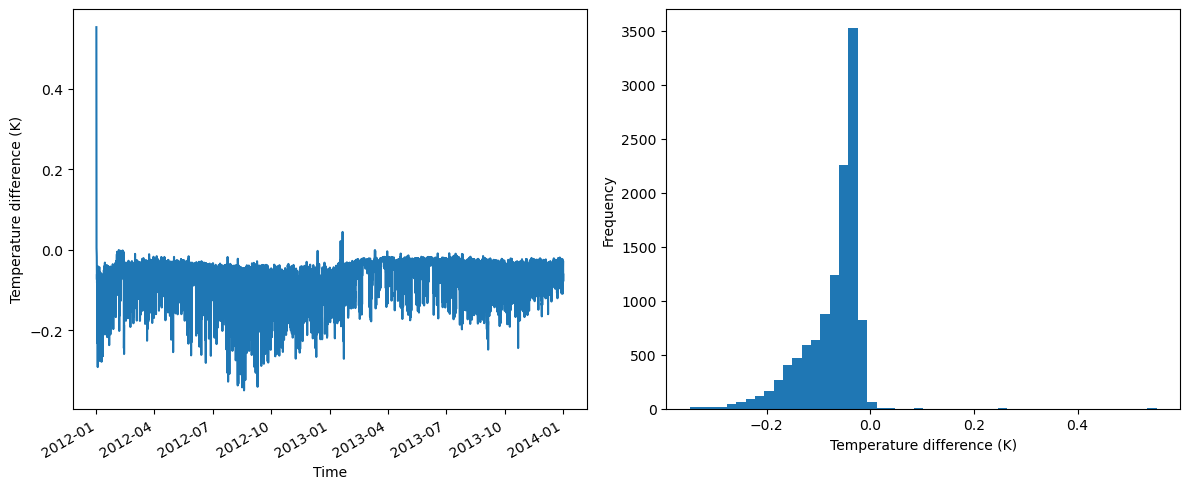

In [14]:
fig = plt.figure(figsize=(12, 5))
ds_usp_spinup = ds_usp_spinup.sel(time=slice('2012','2014'))
#
diff = ds_usp_nospinup['TSA_U'] - ds_usp_spinup['TSA_U']

print(diff.mean().values)

ax = fig.add_subplot(121)
diff.plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature difference (K)')

ax = fig.add_subplot(122)
diff.plot.hist(ax=ax, bins=50)

ax.set_xlabel('Temperature difference (K)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
usp.case_clean()